# Data Enabled Predictive Control(DeePC)
This notebook will demonstrate a python implementation of Data Enabled Predictive Control (DeePC).

It will demonstrate DeePC on a simple Double Integrator

In [1]:
# Imports
import numpy as np
from cvxopt import spmatrix, matrix, solvers
from numpy import linalg as nla
from scipy import linalg as sla
from scipy import sparse
from scipy.signal import cont2discrete
from scipy.stats import qmc
from cvxopt.solvers import qp
import cvxpy as cp
from numpy import hstack, inf, ones
from scipy.sparse import vstack
from osqp import OSQP
import matplotlib.pyplot as plt
from matplotlib import  rcParams
plt.rcParams['figure.facecolor'] = '#F6F6F8'
plt.rcParams['axes.facecolor'] = '#F6F6F8'
rcParams['figure.facecolor'] = '#F6F6F8'
rcParams['axes.facecolor'] = '#F6F6F8'
from matplotlib import rc
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import Normalize

## Systems
We will test DeePC on a Double Integrator

In [2]:
import importlib
import systems  # Replace with the module you are working on


### Double Integrator

A simple n-dimensional double integrator can be written as:

$ \dot{x} = Ax + Bu $

$ y = Cx + Du $

Where:
- $x$ is the state vector: $x = [p_{x_1}, p_{x_2}, \ldots, p_{x_n}, v_{x_1}, v_{x_2}, \ldots, v_{x_n}]^T$
- $u$ is the control input: $u = [a_{x_1}, a_{x_2}, \ldots, a_{x_n}]^T$
- $y$ is the output vector: $y = [p_{x_1}, p_{x_2}, \ldots, p_{x_n}]^T$
- $A$, $B$, $C$, and $D$ are the system matrices

These matricies are defined as:

$A = \begin{bmatrix}
\mathbf{0} & I_n \\
\mathbf{0} & \mathbf{0}
\end{bmatrix} $


$ B = \begin{bmatrix}
\mathbf{0} \\
I_n
\end{bmatrix} $

$ C = \begin{bmatrix}
I_n & \mathbf{0}
\end{bmatrix} $

$ D = \mathbf{0} $

For this demonstration, we will use a 2-dimensional double integrator, which means $n=2$. The double integrator has been implemented in the `systems` module, which can be found in the `systems.py` file.

I will be using [cont2discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) from scipy to discretize the system.

In [3]:
from systems import DoubleIntegrator
importlib.reload(systems)  # Reload the module

<module 'systems' from 'c:\\Users\\sanji\\Documents\\School\\Classes\\271D\\Final Project\\systems.py'>

#### System Implementation
First, I will demonstrate the system with a few tests:
1. No Noise & No Input: This should do absolutely nothing, since the system is not moving.
2. Noise & No Input: This should move the system around, but not in a specific direction.
3. No Noise & Input: This will just move the system around to some position

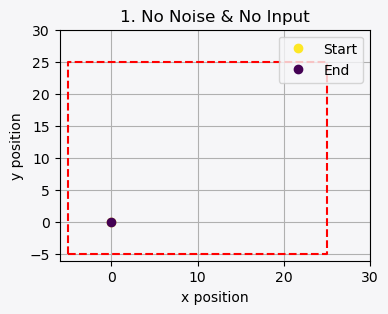

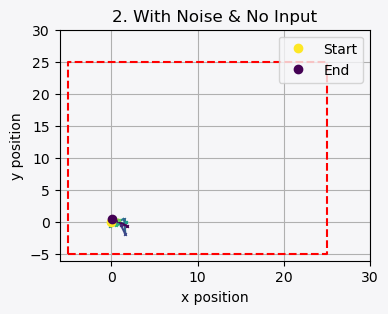

Input Constraints violated for input 0: 2.3 not in [-1  1]
Input Constraints violated for input 1: 1.0499999999999998 not in [-1  1]
Input Constraints violated for input 1: 1.2249999999999999 not in [-1  1]
Input Constraints violated for input 1: 1.4 not in [-1  1]
Input Constraints violated for input 1: 1.575 not in [-1  1]
Output Constraints violated for output 0: 25.710620208891537 not in [-5 25]


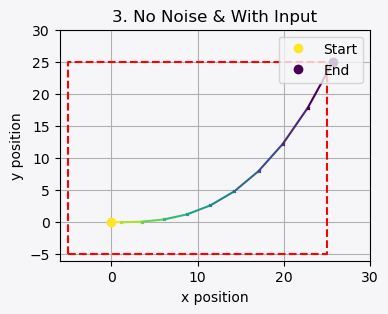

In [4]:
y_box_constraints = np.array([[-5, 25], [-5, 25]])
input_box_constraints = np.array([[-1, 1], [-1, 1]])
system1 = DoubleIntegrator(dt=0.1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)

# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0, 0])  # No control input
	system1.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system1.plot_trajectory(fig=fig, ax=ax)
# set the title to 1. No Noise & No Input
ax.set_title('1. No Noise & No Input')
plt.show()

noise_profile = (np.zeros(2), np.eye(2)*0.7)  # Mean and covariance for noise
system2 = DoubleIntegrator(dt=0.1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints, noise_profile=noise_profile)
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0, 0])  # No control input
	system2.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system2.plot_trajectory(fig=fig, ax=ax)
# set the title to 2. With Noise & No Input
ax.set_title('2. With Noise & No Input')
plt.show()

system3 = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0.23/(i+0.1), 0.175*i])  # Some control input
	system3.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system3.plot_trajectory(fig=fig, ax=ax)
# set the title to 3. No Noise & With Input
ax.set_title('3. No Noise & With Input')
plt.show()

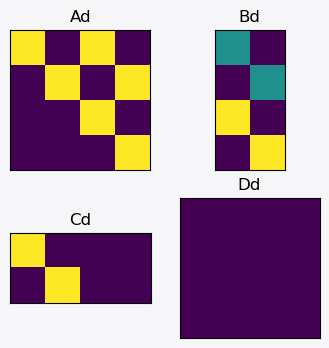

System matrices:
Ad: [[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Bd: [[0.5 0. ]
 [0.  0.5]
 [1.  0. ]
 [0.  1. ]]
Cd: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Dd: [[0. 0.]
 [0. 0.]]


In [5]:
# Lets also print/plot the system matrices
# 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
ax[0, 0].imshow(system3.Ad, cmap='viridis')
ax[0, 0].set_title('Ad')
ax[0, 1].imshow(system3.Bd, cmap='viridis')
ax[0, 1].set_title('Bd')
ax[1, 0].imshow(system3.Cd, cmap='viridis')
ax[1, 0].set_title('Cd')
ax[1, 1].imshow(system3.Dd, cmap='viridis')
ax[1, 1].set_title('Dd')
# plt.tight_layout()
# remove the x and y ticks
for i in range(2):
	for j in range(2):
		ax[i, j].set_xticks([])
		ax[i, j].set_yticks([])
plt.show()
print("System matrices:")
print("Ad:", system3.Ad)
print("Bd:", system3.Bd)
print("Cd:", system3.Cd)
print("Dd:", system3.Dd)
# Spoiler Alert: I will fairly soon make it clear why I am spending time making this ugly plot

#### Cost and Constraints setup
We will use the default ABCD for the double Integrator, dt=1
**Position Constraints**: between -10 to 10
**Acceleration Constraints**: between -1 to 1

**Initial State & Setpoint Bank** to test from: 
1. $[0, 0, 0, 0]$
2. $[0, 0, 0, 5]$
3. $[5, 5, 0, 0]$
4. $[7, -6, -5, -0.5]$
5. $[-3, 2, 0.5, 0]$
6. $[0, 0, -2.5, -4]$

**Control Horizon**: 5

**Sim Steps**: 10

**Cost Function**:
$$ J = \sum_{i=0}^{N-1} \left\lVert x_k - x_{ref}\right\rVert_Q^2  + \left\lVert u_k\right\rVert_R^2 $$

**Quadratic cost matrices**:
$Q = I$, $Qf = 5I$ and $R = 2I$

**Noise:**
We will test 0 mean noise and steady state noise.

$\mu_1 = 0$

$\mu_2 = 0.1$

$\sigma = \begin{bmatrix}
0.1 & 0.05 \\
0.05 & 0.04
\end{bmatrix}$

In [6]:
mu_1 = np.zeros(2)
mu_2 = 0.1*np.ones(2)
sigma = np.array([
    [0.1, 0.05],
	[0.05, 0.04]
])

dt = 1
x01 = np.zeros(4)
x02 = np.array([0, 0, -2, -1])
x03 = np.array([5, 5, 0, 0])
x04 = np.array([7, 6, -5, 0.5])
x05 = np.array([-3, 2, 0.5, 0])
x06 = np.array([0, 0, -2.5, -4])

y_box_constraints = np.array([[-10, 10], [-10, 10]])
input_box_constraints = np.array([[-1, 1], [-1, 1]])
Q = np.eye(4)
Qf = 5*np.eye(4)
R = 2*np.eye(2)
Qy = np.eye(2) # Cost for DeePC & Evaluation
Qfy = 5*np.eye(2)

#### MPC Controller
We will demonstrate an MPC controller to show how this system can be controlled with a standard MPC implementation.

In [7]:
def optimalControlInput(system, setpoint, Q, Qf, R, horizon=5):
	x0 = system.get_state() # current state
	y0 = system.get_y() # current output
	n_input, n_state, n_y = system.n_input, system.n_state, system.n_y
	y_box_constraints = system.y_box_constraints
	input_box_constraints = system.input_box_constraints
	setpoint = np.tile(setpoint, horizon+1) # this is unstacked: [setpoint, setpoint, ..., setpoint], where setpoint = [px, py, vx, vy]

	x = cp.Variable((n_state*(horizon+1))) # this is unstacked: [x0, x1, x2, ..., xN], where xi = [pxi, pyi, vxi, vyi]
	u = cp.Variable((2*horizon)) # this is unstacked: [u0, u1, u2, ..., uN-1], where ui = [uxi, uyi] # 2 is hardcoded since its a double integrator
	y = cp.Variable((n_y*(horizon+1)))  # this is unstacked: [y0, y1, y2, ..., yN], where yi = [pxi, pyi]

	# First, lets setup the cost function
	Q_stacked = sparse.kron(np.eye(horizon), Q).toarray()
	Q_stacked = sla.block_diag(Q_stacked, Qf)
 
	R_stacked = sparse.kron(sparse.eye(horizon), R)
	
	cost = cp.quad_form(x - setpoint, Q_stacked) + cp.quad_form(u, R_stacked)
	# setup the constraints

	Ad = system.Ad
	Bd = system.Bd
	Cd = system.Cd
	Dd = system.Dd

	# TODO: Setup x_k+1 = A*x_k + B*u_k
	constraints = []
	for k in range(horizon):
		x_k = x[n_state * k:n_state * (k + 1)]  # Get state at time k
		x_k_next = x[n_state * (k + 1):n_state * (k + 2)]  # Get state at time k+1
		u_k = u[n_input * k:n_input * (k + 1)]  # Get control input at time k
		y_k = y[n_y * k:n_y * (k + 1)]  # Get output at time k
		
		# State transition constraint: x_k+1 = A_d * x_k + B_d * u_k
		constraints.append(x_k_next == Ad @ x_k + Bd @ u_k)
		# Output constraint: y_k = C_d * x_k + D_d * u_k
		constraints.append(y_k == Cd @ x_k + Dd @ u_k)
  
		# add box constraints for the state
		if y_box_constraints is not None:
			for i in range(system.n_y):
				constraints.append(y_k[i] >= y_box_constraints[i, 0])
				constraints.append(y_k[i] <= y_box_constraints[i, 1])
		# add box constraints for the input
		if input_box_constraints is not None:
			for i in range(system.n_input):
				constraints.append(u_k[i] >= input_box_constraints[i, 0])
				constraints.append(u_k[i] <= input_box_constraints[i, 1])
		
	# Enforce the initial condition: x_0 = x0 (provided state)
	constraints.append(x[:n_state] == x0)

	problem = cp.Problem(cp.Minimize(cost), constraints)
	# Solve the problem
	problem.solve()
	if problem.status not in ["optimal", "optimal_inaccurate"]:
		print("Problem not solved optimally:", problem.status)
		return None, None
	optimal_input = u.value.reshape((horizon, 2))
	return optimal_input

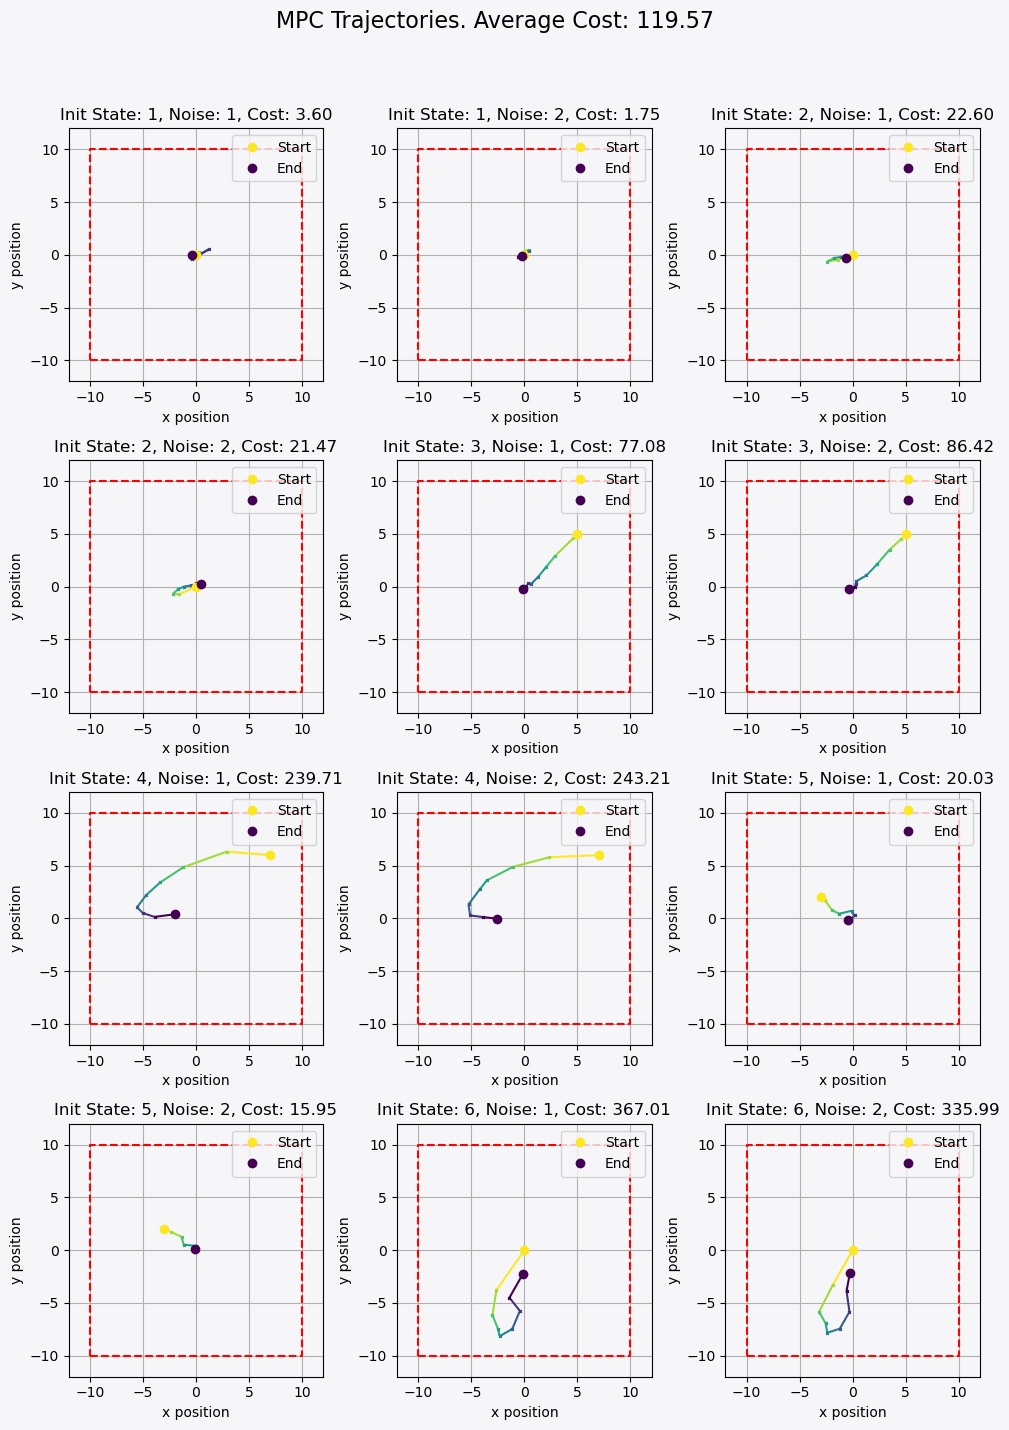

In [8]:
# use x01 as the setpoint
# we have 12 combinations to try, we try from each initial state to the setpoint and with the two different noise profiles
initial_states = [x01, x02, x03, x04, x05, x06]
noise_profiles = [
	(mu_1, sigma),  # Normal noise
	(mu_2, sigma)  # Normal + Steady state noise
]
cost = np.zeros((len(initial_states), len(noise_profiles)))  # To store the cost for each combination
sim_steps = 8  # Number of simulation steps
horizon = 4  # MPC horizon
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
# flatten the axes for easy indexing
axs = axs.flatten()
# create a grid of combinations
for i, initial_state in enumerate(initial_states):
	for j, noise_profile in enumerate(noise_profiles):
		system = DoubleIntegrator(dt=1, initial_state=initial_state, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints, noise_profile=noise_profile)

		for k in range(sim_steps):
			
			horizon = min(horizon, sim_steps - k)  # Adjust horizon if we are at the end of the simulation
			optimal_input = optimalControlInput(system, setpoint=x01, Q=Q, Qf=Qf, R=R, horizon=horizon)
			system.step(optimal_input[0])
			# cp.quad_form(x - setpoint, Q_stacked) + cp.quad_form(u, R_stacked)
			cost[i, j] += (system.y - x01[:2]).T @ Qy @ (system.y - x01[:2]) + optimal_input[0].T @ R @ optimal_input[0]
		cost[i, j] += (system.y - x01[:2]).T @ Qfy @ (system.y - x01[:2])  # Add the final cost
		# Plot the trajectory
		system.plot_trajectory(fig=fig, ax=axs[i * len(noise_profiles) + j])
		# Set the title
		axs[i * len(noise_profiles) + j].set_title(f"Init State: {i+1}, Noise: {j+1}, Cost: {cost[i, j]:.2f}")
fig.suptitle(f'MPC Trajectories. Average Cost: {np.mean(cost):.2f}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.savefig('mpc_trajectories.png', dpi=600)
plt.show()
   

Thats fun to see! The MPC controller also handles steady state error well.

#### DeePC Controller & Experimentation
We will now implement a DeePC controller and compare it to the MPC controller.

##### Hankel Structure
The Hankel Structure is defined as:
$
\mathscr{H}_L(u) := 
\begin{pmatrix}
u_1 & \cdots & u_{T - L + 1} \\
\vdots & \ddots & \vdots \\
u_L & \cdots & u_T
\end{pmatrix}
$

The Hankel matrix is just a sliding window of data. By storing the input and output data history, we can approximate capture the behavior of the system.



For example in a linear system:

$x_{k+1} = Ax + Bu$

So we can say:

$\mathcal{X}_f \approx A\mathcal{X}_p + B\mathcal{U}_p$, which allows us to approximate the system dynamics.
$\begin{bmatrix} A & B \end{bmatrix} \approx \mathcal{X_f} \begin{bmatrix} \mathcal{X_p} \\ \mathcal{U_p} \end{bmatrix}^{\dagger}$


In [9]:
def block_hankel(data, L):
	data = data.T
	nmp = data.shape[0] # nmp means the number of n/m/p, aka how many "state"/"input" variables we have
	T = data.shape[1] # T means the number of time steps we have available
	# L is the length of the block hankel matrix, aka context length
	# we need to create:
	# [data[0], data[1], data[2], ... data[T-L]]
	# [data[1], data[2], data[3], ... data[T-L+1]]
	# ...
	# [data[L-1], data[L], data[L+1], ... data[T-1]]
	# we will start by making a 3D tensor of shape (L, T-L+1, nmp)
	block = np.zeros((L, T-L+1, nmp))
	for i in range(L):
		block[i, :, :] = data[:, i:T-L+1+i].T
	# we need to make it such each state var is in the columns, so it should end up being (L*nmp, T-L+1)
	block = block.transpose(0, 2, 1) # this will make it (L, nmp, T-L+1)
	block = block.reshape((L*nmp, T-L+1)) # this will make it (L*nmp, T-L+1)
	return block

Lets actually try extracting the AB matricies with the help of the Hankel structure.

Look back at the `system` variable. This should have data from the Initial State 6 + Steady State Noise case.

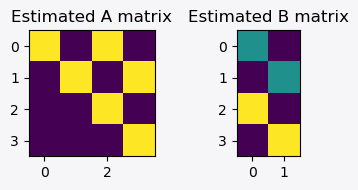

Estimated A matrix:
[[ 1. -0.  1.  0.]
 [ 0.  1.  0.  1.]
 [-0.  0.  1.  0.]
 [-0.  0. -0.  1.]]
Estimated B matrix:
[[ 0.5 -0. ]
 [ 0.   0.5]
 [ 1.   0. ]
 [-0.   1. ]]


In [10]:
u_off_data = np.array(system.input_history)
x_off_data = np.array(system.state_history[:len(u_off_data)])
# We will first estimate the state transition, for which the order is just 1
order = 1
context = 1 # We only need one context step

Hu = block_hankel(u_off_data, order + context)
Hy = block_hankel(x_off_data, order + context)
Up = Hu[:system.n_input*order, :]
Xp = Hy[:system.n_state*order, :]
Uf = Hu[system.n_input*order:, :]
Xf = Hy[system.n_state*order:, :]

# Now we can estimate the state transition matricies
XpUp = np.vstack((Xp, Up))
AB_est = Xf @ nla.pinv(XpUp)
A_est = AB_est[:, :system.n_state]
B_est = AB_est[:, system.n_state:]
# Rounding for better readability
A_est = np.round(A_est, 2)
B_est = np.round(B_est, 2)
# plot the estimated state transition matrices
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(A_est, cmap='viridis')
ax[0].set_title('Estimated A matrix')
ax[1].imshow(B_est, cmap='viridis')
ax[1].set_title('Estimated B matrix')
plt.tight_layout()
plt.show()
print("Estimated A matrix:")
print(A_est)
print("Estimated B matrix:")
print(B_est)

That should look familiar! This demonstrates how the Hankel structure can be used to approximate the system dynamics.

For a linear system, we can easily extract the AB matricies from the Hankel structure. For nonlinear or black box systems, we can still use the Hankel structure to approximate the system dynamics as long as we have wide coverage of the input and output data.

Now, instead of using 

$\begin{bmatrix} A & B \end{bmatrix} \approx \mathcal{X_f} \begin{bmatrix} \mathcal{X_p} \\ \mathcal{U_p} \end{bmatrix}^{\dagger}$
we can `remember` the systems behavior at any given context by using the data with the highest correlation to the current context. 
This is done by 
$
\begin{pmatrix}
U_p \\
Y_p \\
U_f \\
Y_f
\end{pmatrix}
g =
\begin{pmatrix}
u_{\mathrm{ini}} \\
y_{\mathrm{ini}} \\
u \\
y
\end{pmatrix}
$

g is the weight vector that is used to estimate what linear combination of past data is most relevant to the current context.

Since this is a linear system a context length of 1 is sufficient, but for nonlinear or black box systems, we can use a longer context length to capture more of the system's behavior(increasing the context length on linear systems prevents us from extracing the AB matrices, additionally estimating too large of a context length on nonlinear or black box systems can lead to overfitting).

In [11]:
class DeePC:
	def __init__(self, system, T=100, order_estimate=2):
		"""
		DeePC class for Data Efficient Predictive Control (DeePC) implementation.
		Args:
			system: The system to be controlled, should have methods step() and get_state().
			horizon: Prediction/Control horizon for the control inputs.
			T: Length of the input sequence for offline data collection.
			order_estimate: How much context we believe the system requires
		"""
		self.system = system
		self.n_input = system.n_input  # number of input variables
		self.n_state = system.n_state # number of state variables
		self.n_y = system.n_y  # number of output variables # this is 2 for a 2D system
		self.default_y_box_constraints = self.system.y_box_constraints
		self.default_input_box_constraints = self.system.input_box_constraints
  
		self.T = T  # Length of Offline data collection sequence
		self.order_estimate = order_estimate  # length of the input sequence for the initial condition

		# offline data collection storage
		self.U_off_list = []  # Control inputs
		self.Y_off_list = []  # Outputs
		self.U_off_data = None # Numpy array of control inputs
		self.Y_off_data = None

		# online data list
		self.U_on_list = []
		self.Y_on_list = []
		self.u_ini = None # Numpy array of control inputs
		self.y_ini = None

		# Hankel matrices
		self.Hu = None
		self.Hy = None

		self.Up = None
		self.Uf = None
		self.Yp = None
		self.Yf = None

	def disable_box_constraints(self):
		# disable box constraints
		self.system.y_box_constraints = None
		self.system.input_box_constraints = None
  
	def enable_box_constraints(self):
		self.system.y_box_constraints = self.default_y_box_constraints
		self.system.input_box_constraints = self.default_input_box_constraints

  
	def collect_offline_data(self, U=None):
		# first, disable the box constraints so that we can collect data
		self.disable_box_constraints()
		# Collect data for DeePC by creating a random input sequence
		if U is None:
			U = np.random.uniform(-1, 1, (self.T, self.n_input))
		U = np.array(U)

		for u in U:
			# set the state
			self.Y_off_list.append(self.system.y)
			self.system.step(u)
			self.U_off_list.append(u)
		
		self.U_off_data = np.array(self.U_off_list)
		self.Y_off_data = np.array(self.Y_off_list)
  
		# now, we can restore the box constraints
		self.enable_box_constraints()
  
	def step_and_collect(self, u):
		# this will step and collect online data

		self.U_on_list.append(u)
		self.system.step(u)
		self.Y_on_list.append(self.system.y)
  
  
		# we only need the last order_estimate steps of data to get the initial condition/context
		self.U_on_list = self.U_on_list[-self.order_estimate:]
		self.Y_on_list = self.Y_on_list[-self.order_estimate:]
		self.u_ini = np.array(self.U_on_list).flatten()
		self.y_ini = np.array(self.Y_on_list).flatten()

	def build_hankel(self, horizon):
		# build the hankel matrices from the offline data
		L = horizon + self.order_estimate
		self.Hu = block_hankel(self.U_off_data, L)
		self.Hy = block_hankel(self.Y_off_data, L)

		n_input, n_y = self.n_input, self.n_y
		self.Up = self.Hu[:n_input * self.order_estimate, :]
		self.Uf = self.Hu[n_input * self.order_estimate:, :]
		self.Yp = self.Hy[:n_y * self.order_estimate, :]
		self.Yf = self.Hy[n_y * self.order_estimate:, :]

	def solve(self, setpoint, horizon=10, Q=None, Qf=None, R=None, Lg=1e-6, Ly = 1e-6):
		self.build_hankel(horizon) # first rebuild the hankel matrices
		n_input, n_y = self.n_input, self.n_y

		setpoint = np.tile(setpoint, horizon) # this is unstacked: [setpoint, setpoint, ..., setpoint], where setpoint = [px, py, vx, vy]

		# setup a cp variable for x0 rolled N times
		u = cp.Variable((n_input*(horizon)))
		y = cp.Variable((n_y*(horizon)))
		g = cp.Variable((self.Up.shape[1]))
		sigma_y = cp.Variable((self.Yp.shape[0]))

		# First, lets setup the cost function
		Q_stacked = sparse.kron(np.eye(horizon-1), Q).toarray()
		Q_stacked = sla.block_diag(Q_stacked, Qf)
		R_stacked = sparse.kron(sparse.eye(horizon), R)

		cost = cp.quad_form(y - setpoint, Q_stacked) + cp.quad_form(u, R_stacked) + Lg * cp.norm1(g) + Ly * cp.norm1(sigma_y)

		# setup the DeePC constraints
		constraints = [
			self.Up @ g == cp.vec(self.u_ini, order='F'),
			self.Yp @ g + sigma_y == cp.vec(self.y_ini, order='F'),
			self.Uf @ g == u,
			self.Yf @ g == y,
		]

		# add box constraints
		if self.system.y_box_constraints is not None:
			for i in range(self.n_y):
				constraints.append(y[i] >= self.system.y_box_constraints[i, 0])
				constraints.append(y[i] <= self.system.y_box_constraints[i, 1])
		# add box constraints for the input
		if self.system.input_box_constraints is not None:
			for i in range(self.n_input):
				constraints.append(u[i] >= self.system.input_box_constraints[i, 0])
				constraints.append(u[i] <= self.system.input_box_constraints[i, 1])
  
		prob = cp.Problem(cp.Minimize(cost), constraints)
		prob.solve(solver=cp.SCS)

		if prob.status not in ["optimal", "optimal_inaccurate"]:
			print("Problem not solved optimally:", prob.status)
			return None, None


		# Reshape and return
		u_opt = u.value.reshape(horizon, n_input)
		y_opt = y.value.reshape(horizon, n_y)
		return u_opt, y_opt

In [61]:
# Some Hyperparameters to setup
order_estimate = 4  # Initial condition length. Since we are dealing with a double integrator, we need at least 2 steps to get the initial condition
# the reason why we only needed 1 for AB estimation was because we had position and velocity. This time we only have position
T = 25 # Collect some data points

##### Offline Data Collection

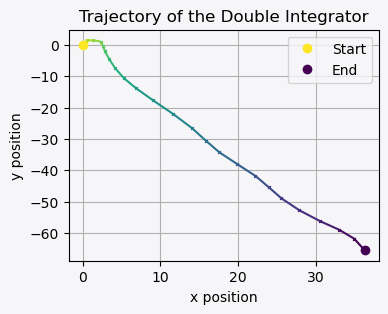

In [62]:
system = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
# Data Collection parameters
deepc = DeePC(system, T=T, order_estimate=order_estimate) # create an instance of DeePC

# collect data
deepc.collect_offline_data()
# Lets see what that trajectory looked like and see if it was rich enough
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
deepc.system.plot_trajectory(fig=fig, ax=ax, limit_chart=False)

We cannot do too much here to stay within the constraints, but in real life offline data collection can be done by a human operator which should be able to cover the state space of the system.

Lets build and visualize the Hankel structure.

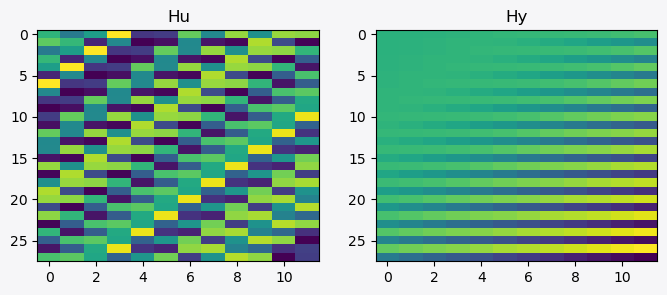

In [63]:
deepc.build_hankel(horizon=10)  # Build the Hankel matrices from the offline data

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
# imshow Hu on the first axis
axs[0].imshow(deepc.Hu, aspect='auto', cmap='viridis')
axs[0].set_title('Hu')
# imshow Hy on the second axis
axs[1].imshow(deepc.Hy, aspect='auto', cmap='viridis')
axs[1].set_title('Hy')
# save this figure as 'deePC_hankel_matrices_imshow.png'
plt.savefig('deePC_hankel_matrices_imshow.png', dpi=600)
plt.show()

Beautiful! This makes sense intuitively, since the hankel matrix is a sliding window, which is why se see so many diagonal structures(the reason why it is structures and not lines is because the input data is a vector so its stacked).

Now we need to collect some initial state data, so we will use an MPC to steer the system to the start

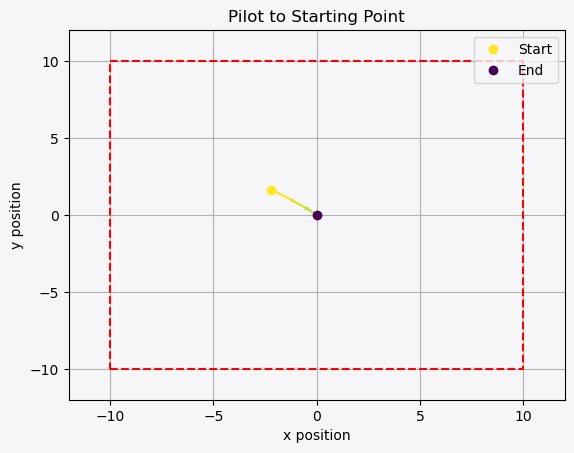

In [64]:
# * Parameters:
des_start = np.array([0, 0, 0, 0])  # Desired starting point before we start DeePC control
N = 20  # Number of steps to take to reach the desired starting point
MPC_horizon = 15  # MPC horizon for the initial condition
store_past = 0 # We do not want to store the trajectories before DeePC control, so we set this to 0
plot = True  # Whether to plot the trajectory or not

def steerDeePCwithMPC(deepcController, mpc_initial_cond, des_start, Q, Qf, R, N, MPC_horizon, store_past, plot):
	# to collect initial condition data, we need to steer the system a bit, we will go to the desired starting point using MPC
	deepcController.system.delete_history()
	deepcController.system.set_state(mpc_initial_cond)
	for i in range(N):
		optimal_input = optimalControlInput(deepcController.system, setpoint=des_start, Q=Q, Qf=Qf, R=R, horizon=min(N - i, MPC_horizon))
		deepcController.step_and_collect(optimal_input[0])
		
	if plot:
		# plot the trajectory
		fig, ax = plt.subplots()
		deepcController.system.plot_trajectory(fig=fig, ax=ax)
		ax.set_title(f'Pilot to Starting Point')
	if store_past is not None:
		deepcController.system.state_history = deepcController.system.state_history[-store_past:]
		deepcController.system.input_history = deepcController.system.input_history[- store_past:]
		deepcController.system.output_history = deepcController.system.y_history[- store_past:]

steerDeePCwithMPC(deepc, x05, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=True)

##### Running DeePC

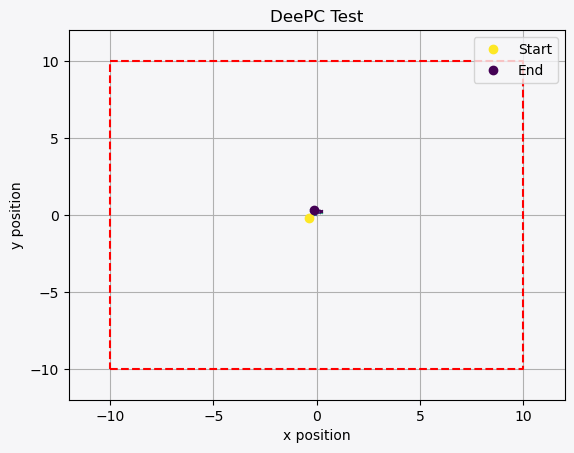

In [65]:
# hyperparameters for DeePC
sim_steps = 8
horizon = 4
Qy = np.eye(2)
Qfy = 5*np.eye(2)
# start by going to the setpoint
steerDeePCwithMPC(deepc, x01, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

# Now that you have u_opt and y_opt, apply the control inputs to the system
# and plot the trajectory

deepc.system.sigma = sigma
setpoint = np.zeros(2)
deepc.system.delete_history()  # Clear the history of the system
for i in range(sim_steps):
	# Solve DeePC
	u_opt, y_opt = deepc.solve(setpoint, horizon=min(sim_steps - i, horizon), Q=Qy, Qf=Qfy, R=R, Lg=20, Ly=1e4)
	u = u_opt[0]
	# print("u:", u)
	deepc.step_and_collect(u)
fig, ax = plt.subplots()
system.plot_trajectory(fig=fig, ax=ax)
ax.set_title('DeePC Test')
plt.show()

DeePC is does a fair job of staying in place when disturbed by external disturbances. Lets give it the same test as the MPC controller and compare the results.

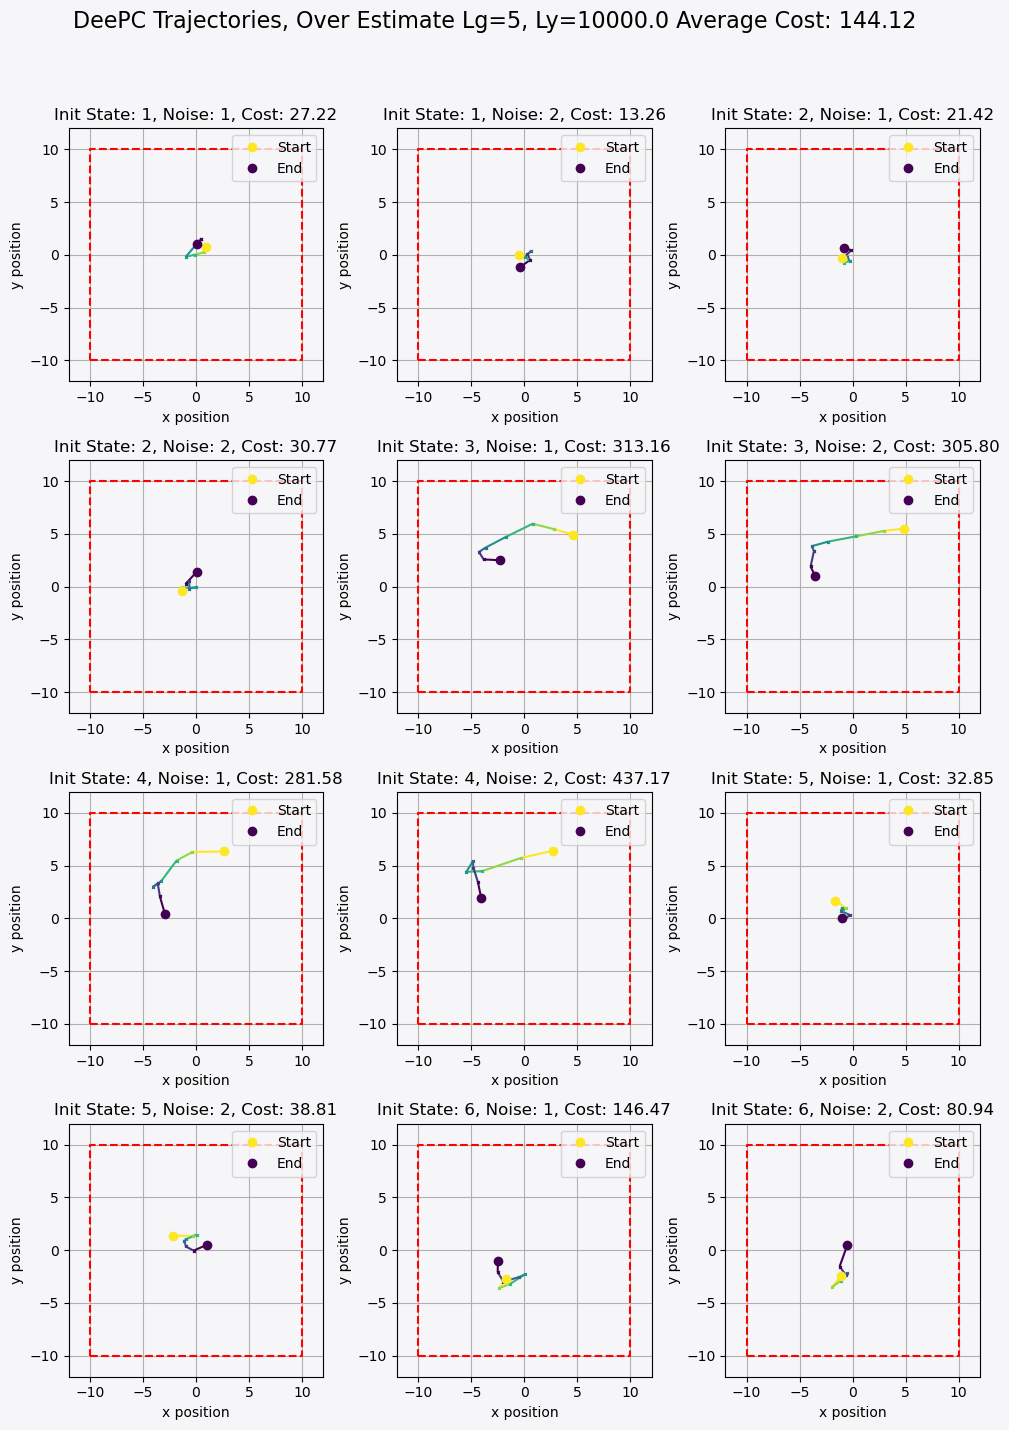

In [66]:
# * Regularization Hyperparameters
Lg = 5		# Model Size regularization
Ly = 1e4	# Model 'Give' Regularization

# use x01 as the setpoint
# we have 12 combinations to try, we try from each initial state to the setpoint and with the two different noise profiles
initial_states = [x01, x02, x03, x04, x05, x06]
noise_profiles = [
	(mu_1, sigma),  # Normal noise
	(mu_2, sigma)  # Normal + Steady state noise
]
cost = np.zeros((len(initial_states), len(noise_profiles)))  # To store the cost for each combination
sim_steps = 8  # Number of simulation steps
horizon = 4  # MPC horizon
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
# flatten the axes for easy indexing
axs = axs.flatten()
# create a grid of combinations
for i, initial_state in enumerate(initial_states):
	for j, noise_profile in enumerate(noise_profiles):
		deepc.system.mu, deepc.system.sigma = noise_profile
		steerDeePCwithMPC(deepc, x01, initial_state, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

		setpoint = np.zeros(2)
		deepc.system.delete_history()  # Clear the history of the system
		for k in range(sim_steps):
			# Solve DeePC
			u_opt, y_opt = deepc.solve(setpoint, horizon=min(sim_steps - k, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
			u = u_opt[0]
			# print("u:", u)
			deepc.step_and_collect(u)
			cost[i, j] += (system.y - x01[:2]).T @ Qy @ (system.y - x01[:2]) + u.T @ R @ u
		cost[i, j] += (system.y - x01[:2]).T @ Qfy @ (system.y - x01[:2])  # Add the final cost
		# Plot the trajectory
		system.plot_trajectory(fig=fig, ax=axs[i * len(noise_profiles) + j])
		# Set the title
		axs[i * len(noise_profiles) + j].set_title(f"Init State: {i+1}, Noise: {j+1}, Cost: {cost[i, j]:.2f}")
fig.suptitle(f'DeePC Trajectories, Over Estimate Lg={Lg}, Ly={Ly} Average Cost: {np.mean(cost):.2f}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.savefig(f'DeePC_trajectories_oe_{Lg}_{Ly}.png', dpi=600)
plt.show()

This performs fairly well for a linear system, handling steady state error quite well too.